In [1]:
# ===============================
# 1. Setup & Installation
# ===============================

!pip install tensorflow kagglehub matplotlib numpy pillow --quiet

# ===============================
# 2. Import Libraries
# ===============================
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub

In [2]:
# ===============================
# 3. Download Dataset via KaggleHub Problem & Dataset:
# The task is binary classification of video frames as violent or non-violent using the “Real-Life Violence and Non-Violence Dataset.”
# ===============================
path = kagglehub.dataset_download("karandeep98/real-life-violence-and-nonviolence-data")
print("✅ Dataset downloaded to:", path)

# Inspect contents to find dataset folder
print("Contents:", os.listdir(path))

# In this dataset, images are stored inside `violence_dataset`
DATASET_PATH = os.path.join(path, "violence_dataset")

# ===============================
# 4. Define Constants
# ===============================
IMG_SIZE = (224, 224)   # ResNet50 input size trained on 224x224 images
BATCH_SIZE = 32
NUM_CLASSES = 1         # Binary classification ( Violence / Non-Violence )
EPOCHS = 5


Using Colab cache for faster access to the 'real-life-violence-and-nonviolence-data' dataset.
✅ Dataset downloaded to: /kaggle/input/real-life-violence-and-nonviolence-data
Contents: ['violence_dataset']


In [3]:
# ===============================
# 5. Load and Prepare Dataset [# This automatically creates labels based on folder names ('violence', 'non_violence')
# We'll create a single dataset first and then split it.]
# ===============================
full_dataset = image_dataset_from_directory(
    DATASET_PATH,
    labels='inferred',
    label_mode='binary', # For binary_crossentropy loss
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Split into train, validation, and test sets (70% training /15% training/15% testing)
# Calculate the sizes for each split
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

#Split the dataset
train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size).take(val_size)
test_dataset = full_dataset.skip(train_size + val_size).take(test_size)

# Preprocess for ResNet50
def preprocess_data(image, label):
    # Applies ResNet - 50 specific preprocessing
    return preprocess_input(image), label

# # Apply preprocessing to all datasets
train_dataset = train_dataset.map(preprocess_data).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(preprocess_data).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(preprocess_data).prefetch(tf.data.AUTOTUNE)

print(f"✅ Total batches: {dataset_size}")
print(f"✅ Training: {len(train_dataset)} | Validation: {len(val_dataset)} | Test: {len(test_dataset)}")


Found 11063 files belonging to 2 classes.
✅ Total batches: 346
✅ Training: 242 | Validation: 51 | Test: 53


In [4]:
# ===============================
#  6. Build the ResNet50 Model
#  Load the ResNet-50 base model pre-trained on ImageNet
#  ⁠include_top=False ⁠ removes the final classification layer
#  Model & Training: ResNet50 (pretrained on ImageNet) is used with frozen convolutional layers and a small dense head.
#  So, using a CNN backbone (like ResNet50): Provides strong pre-trained spatial representations. Reduces the amount of data and compute needed (since it transfers knowledge from ImageNet). Makes training faster and more stable.
# ===============================
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False  # freeze pre-trained layers

# Create the final model by adding custom layers on top of the base model
# 2D CNN model usage advantages: Simpler and faster. Leverages proven pre-trained CNNs (e.g., ResNet, VGG, MobileNet). Works well when temporal cues are mild or when the goal is frame-wise classification.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Reduces spatial dimensions to a single vector
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(NUM_CLASSES, activation='sigmoid') # Output layer for binary classification
])
# --- Justification for Architecture Choice ---
# 1. Why ResNet-50? It's a deep, powerful architecture that has learned rich feature representations from the ImageNet dataset. Its residual connections help prevent the vanishing gradient problem in deep networks.
# 2. Transfer Learning: We use transfer learning to leverage these pre-trained features, which is much more effective than training from scratch, especially with a smaller dataset. We only need to train a simple classifier on top.
# 3. Handling Video Data: This model processes frames spatially. It classifies based on the content of individual images, assuming violent acts are visible within single frames. It does not capture temporal (time-based) information. [cite: 35]

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# ===============================
# 7. Compile & Train the Model
# Optimizer: Adam is a good default choice.
# Loss: 'binary_crossentropy' is used for two-class problems.
# Metrics: We want to monitor 'accuracy'.
# ===============================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("\n--- 🚀 Starting Model Training ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)
print("--- ✅ Training Complete ---")



--- 🚀 Starting Model Training ---
Epoch 1/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 1782s 7s/step - accuracy: 0.8767 - loss: 0.3053 - val_accuracy: 0.9308 - val_loss: 0.2003
Epoch 2/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 1814s 7s/step - accuracy: 0.9108 - loss: 0.2169 - val_accuracy: 0.9418 - val_loss: 0.1640
Epoch 3/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 1747s 7s/step - accuracy: 0.9174 - loss: 0.1994 - val_accuracy: 0.9412 - val_loss: 0.1567
Epoch 4/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 1859s 8s/step - accuracy: 0.9290 - loss: 0.1906 - val_accuracy: 0.9504 - val_loss: 0.1351
Epoch 5/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 1777s 7s/step - accuracy: 0.9298 - loss: 0.1829 - val_accuracy: 0.9522 - val_loss: 0.1362
--- ✅ Training Complete ---


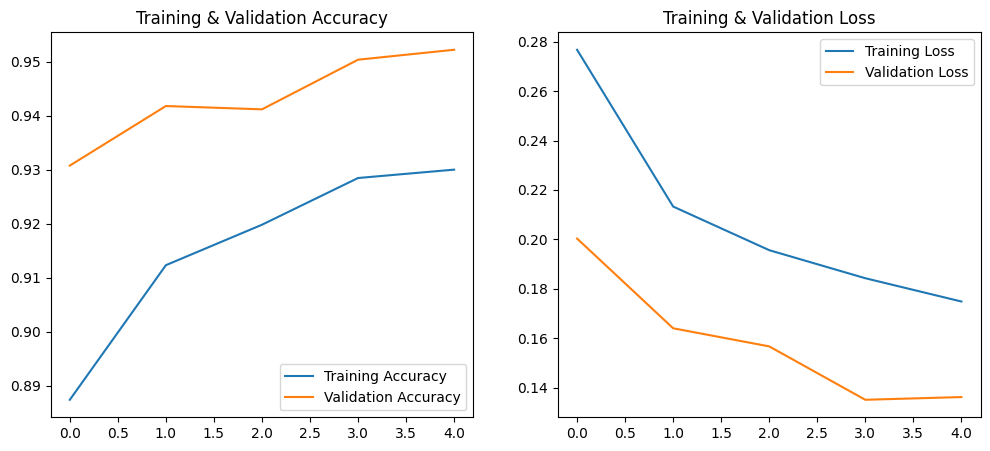

In [7]:
# ===============================
# 8. Plot Training Curves
# ===============================
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')
    plt.show()

plot_history(history)


In [8]:
# ===============================
# 9. Evaluate on Test Set
# ===============================
print("\n--- Evaluating on Test Set ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"✅ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")


--- Evaluating on Test Set ---
53/53 ━━━━━━━━━━━━━━━━━━━━ 344s 6s/step - accuracy: 0.9490 - loss: 0.1231
✅ Test Accuracy: 95.49%
✅ Test Loss: 0.1184
